In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *
%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    '''
    s_main, sf_main =  eat_snap_and_fof(level, halo_number, 127, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 
    s_main.data['gmet'] = np.maximum( s_main.data['gmet'], 1e-40 )
    istars, = np.where( (s.type == 4) & (s.halo == 0) )
    (x_main_Mpc, y_main_Mpc, z_main_Mpc), (vx_main_Mpc, vy_main_Mpc, vz_main_Mpc), rxyz_main_Mpc, rxy_main_Mpc = get_cartesian_vectors(s, sf, istars)
    '''
    for snapnr in [127]:
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [22]:
def dwarf_selection(s, sf, z_kpc_val, level, halo_number, snapnr, snappath, subhalonr, partnr, verbose = True, outplot = True, outfile = False, saveplot = False):
    '''
    NAME: 
        dwarf_selection
    INPUT:
        s, sf: z=0 snapshot
        z_kpc: absolute disk height in kpc
        level, halo_number, snapnr, snappath: snapshot in which dwarf is selected (INT; 0 < snapnr < 127)
        subhalonr: which subhalo should be selected (INT; 0 < subhalonr)
        partnr: number of random selected dwarf particles (INT)
        outplot: if True, plots marked dwarf in early and z=0 snapshot; default = True
        outfile: if True, saves information on dwarfs in file; default = False
    HISTORY:
        02-02-2018: written (Milanov, ESO)
    '''
    # read in early snapshot
    try:
        es, esf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
                haloid=0, galradfac=0.1, verbose=False)   
    except KeyError:
        return
    except IndexError:
        return
    es.data['gmet'] = np.maximum( es.data['gmet'], 1e-40 )
    
    
    if isinstance(subhalonr, list):
        outstr = ''

        for item in subhalonr:
            istarssub, = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == item) )
            try:
                istarssubsample = np.random.choice(istarssub, partnr)
            except ValueError:
                break
            #istarssubsample = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == 1) & (1000. * np.abs(es.pos[::,0]) > z_kpc))
            ids_halo1 = es.id[istarssubsample]
            ids_halo1 = es.id[istarssub]



            istars, = np.where( (s.type == 4) & (s.halo == 0) )
            (x_kpc, y_kpc, z_kpc), (vx_kpc, vy_kpc, vz_kpc), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, istars)
            istarse, = np.where( (es.type == 4) & (es.halo == 0) )
            (ex_kpc, ey_kpc, ez_kpc), (evx_kpc, evy_kpc, evz_kpc), erxyz_kpc, erxy_kpc = get_cartesian_vectors(es, esf, istarse)

            subhalomask = np.isin(s.id[istars], ids_halo1)
            esubhalomask = np.isin(es.id[istarse], ids_halo1)
            z_sample = np.where((np.abs(z_kpc) > z_kpc_val) & (rxyz_kpc < 5. * 1000. * s.galrad), True, False)


            survivors = np.sum(z_sample * subhalomask)
            starters = np.sum(esubhalomask)
            frac = round(survivors/starters, 3)
            outstr += '\tSH:' + str(item) + '\t' + str(frac) + '\t' + str(survivors) + '\t' + str(starters)

            if verbose == True:
                print('Snapshot number:', snapnr,'\nfraction:', survivors , starters, frac, '\n')
            if outplot == True:
                fig, axes = plt.subplots(2, 2, figsize=(12, 12))     
                axes[0, 0].set_title('Snapshot {:d}, Subhalo {:d}'.format(snapnr, item))
                axes[0, 0].hist2d(ex_kpc, ey_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
                axes[0, 0].plot(ex_kpc[esubhalomask], ey_kpc[esubhalomask], '.', alpha = 0.2, color = 'xkcd:hot pink')
                axes[0, 0].set_xlabel("x")
                axes[0, 0].set_ylabel("y")
                axes[0, 0].set_aspect('equal')
                axes[0, 1].hist2d(erxy_kpc, ez_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
                axes[0, 1].plot(erxy_kpc[esubhalomask], ez_kpc[esubhalomask], '.', alpha = 0.2, color = 'xkcd:hot pink')
                axes[0, 1].set_xlabel("R")
                axes[0, 1].set_ylabel("z")
                axes[0, 1].set_aspect('equal')

                axes[1, 0].hist2d(x_kpc, y_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
                axes[1, 0].plot(x_kpc[z_sample * subhalomask], y_kpc[z_sample * subhalomask], '.', alpha = 0.2, color = 'xkcd:hot pink')
                axes[1, 0].set_xlabel("x")
                axes[1, 0].set_ylabel("y")
                axes[1, 0].set_aspect('equal')
                axes[1, 1].set_title('Disk height = {:.1f} kpc'.format(2.*z_disk_kpc))
                axes[1, 1].hist2d(rxy_kpc, z_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
                axes[1, 1].plot(rxy_kpc[z_sample * subhalomask], z_kpc[z_sample * subhalomask], '.', alpha = 0.2, color = 'xkcd:hot pink')
                axes[1, 1].set_xlabel("R")
                axes[1, 1].set_ylabel("z")
                axes[1, 1].set_aspect('equal')
                #fig.show()
            if saveplot == True:
                fig.savefig('/home/extmilan/masterthesis/plots/dwarf_selection_snap_{:d}_SH_{:d}.png'.format(snapnr, item), dpi=300, facecolor='w', edgecolor='w',format='png')
            
        snap_time = s.cosmology_get_lookback_time_from_a( es.time, is_flat=True )
        snap_redshift = es.redshift
        #survivor_age = star_age[z_sample * subhalomask]
        if outfile == True:
            with open('/home/extmilan/masterthesis/files/test2.txt','a') as f:
                f.write(str(snapnr) + '\t' + str(snap_time) + '\t' + str(snap_redshift) + outstr + '\n')
   

    else:
        istarssub, = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == subhalonr) )
        istarssubsample = np.random.choice(istarssub, partnr)
        #istarssubsample = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == 1) & (1000. * np.abs(es.pos[::,0]) > z_kpc))
        ids_halo1 = es.id[istarssubsample]
        ids_halo1 = es.id[istarssub]



        istars, = np.where( (s.type == 4) & (s.halo == 0) )
        (x_kpc, y_kpc, z_kpc), (vx_kpc, vy_kpc, vz_kpc), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, istars)
        istarse, = np.where( (es.type == 4) & (es.halo == 0) )
        (ex_kpc, ey_kpc, ez_kpc), (evx_kpc, evy_kpc, evz_kpc), erxyz_kpc, erxy_kpc = get_cartesian_vectors(es, esf, istarse)

        subhalomask = np.isin(s.id[istars], ids_halo1)
        esubhalomask = np.isin(es.id[istarse], ids_halo1)
        z_sample = np.where((np.abs(z_kpc) > z_kpc_val) & (rxyz_kpc < 5. * 1000. * s.galrad), True, False)


        survivors = np.sum(z_sample * subhalomask)
        starters = np.sum(esubhalomask)
        frac = round(survivors/starters, 3)

        snap_time = s.cosmology_get_lookback_time_from_a( es.time, is_flat=True )
        snap_redshift = es.redshift
        #survivor_age = star_age[z_sample * subhalomask]


        if verbose == True:
            print('Snapshot number:', snapnr,'\nfraction:', survivors , starters, frac, '\n')
        if outplot == True:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))     
            axes[0, 0].set_title('Snapshot {:d}, Subhalo {:d}'.format(snapnr, subhalonr))
            axes[0, 0].hist2d(ex_kpc, ey_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
            axes[0, 0].plot(ex_kpc[esubhalomask], ey_kpc[esubhalomask], '.', alpha = 0.3, color = 'xkcd:hot pink')
            axes[0, 0].set_xlabel("x")
            axes[0, 0].set_ylabel("y")
            axes[0, 0].set_aspect('equal')
            axes[0, 1].hist2d(erxy_kpc, ez_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
            axes[0, 1].plot(erxy_kpc[esubhalomask], ez_kpc[esubhalomask], '.', alpha = 0.3, color = 'xkcd:hot pink')
            axes[0, 1].set_xlabel("R")
            axes[0, 1].set_ylabel("z")
            axes[0, 1].set_aspect('equal')
            
            axes[1, 0].set_title('Snapshot {:d}'.format(127))
            axes[1, 0].hist2d(x_kpc, y_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
            axes[1, 0].plot(x_kpc[z_sample * subhalomask], y_kpc[z_sample * subhalomask], '.', alpha = 0.3, color = 'xkcd:hot pink')
            axes[1, 0].set_xlabel("x")
            axes[1, 0].set_ylabel("y")
            axes[1, 0].set_aspect('equal')
            axes[1, 1].set_title('Disk height = {:.1f} kpc'.format(2.*z_disk_kpc))
            axes[1, 1].hist2d(rxy_kpc, z_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
            axes[1, 1].plot(rxy_kpc[z_sample * subhalomask], z_kpc[z_sample * subhalomask], '.', alpha = 0.3, color = 'xkcd:hot pink')
            axes[1, 1].set_xlabel("R")
            axes[1, 1].set_ylabel("z")
            axes[1, 1].set_aspect('equal')
            #fig.show()
        if saveplot == True:
            fig.savefig('/home/extmilan/masterthesis/plots/dwarf_selection_snap_{:d}_SH_{:d}.png'.format(snapnr, subhalonr), dpi=300, facecolor='w', edgecolor='w',format='png')


        if outfile == True:
            with open('/home/extmilan/masterthesis/files/test.txt','a') as f:
                f.write(str(snapnr) + '\t' + str(snap_time) +  '\t' + str(snap_redshift) + '\t' + str(frac) + '\t' + str(survivors) + '\t' + str(starters) + '\n')

[ 13.4669323   12.98056126  13.84910297]
Found 371337 stars.
Rotated pos.
Rotated vel.
Snapshot number: 67 
fraction: 33925 49161 0.69 



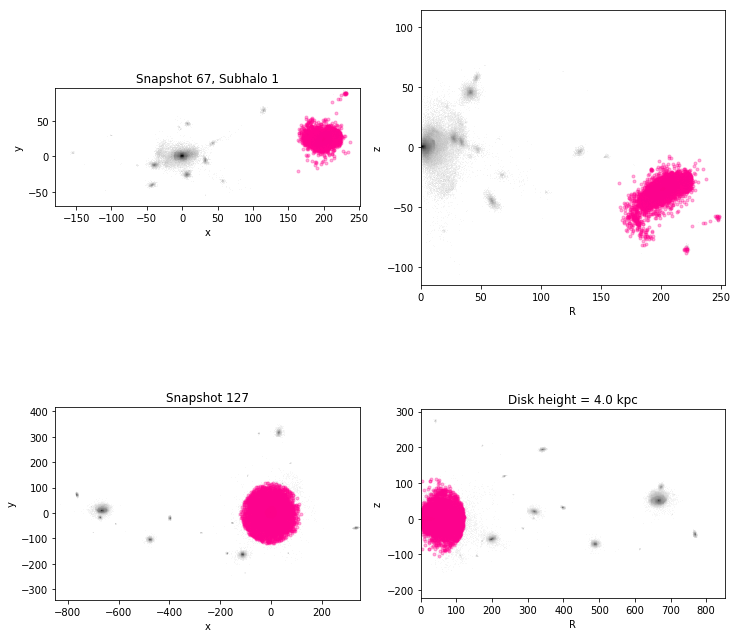

In [23]:
halo_number = 24
halodir = basedir+"halo_{0}/".format(halo_number)
snappath = halodir+"output/"
z_disk_kpc = 2

first_comm = 'Halo ' + str(halo_number) + '; disk_height: ' + str(z_disk_kpc) +\
'\nSnapnr; Age; Redshift; Subhalo number; surviving fraction; number of survivors; number of dwarf particles (can be repeated)\n'
with open('/home/extmilan/masterthesis/files/test2.txt','a') as f:
    f.write(first_comm)
for i in range(67,68,1):
    dwarf_selection(s, sf, z_disk_kpc, level, halo_number, i, snappath, 1, 50, outfile = False, outplot= True, saveplot = True)

In [32]:
def dwarf_following(Galrad, snappath, start_snap_nr, end_snap_nr = 127, subhalonr = 1, level = 4, halo_number = 24, outplot = True):
    try:
        es, esf = eat_snap_and_fof(level, halo_number, start_snap_nr, snappath, loadonlytype=[4], 
                haloid=0, galradfac=0.1, verbose=False)   
    except KeyError:
        print('Start snapshot does not contain stars.')
        return
    except IndexError:
        print('Start snapshot does not contain stars.')
        return
    istarssub, = np.where( (es.type == 4) & (es.halo == 0) & (es.subhalo == subhalonr) )
    #istarssubsample = np.random.choice(istarssub, partnr)
    #ids_halo1 = es.id[istarssubsample]
    ids_halo1 = es.id[istarssub]
    
    for i in range(start_snap_nr, end_snap_nr + 1, 1):
        fs, fsf = eat_snap_and_fof(level, halo_number, i, snappath, loadonlytype=[4], 
                haloid=0, galradfac=0.1, verbose=False)   
        
        '''
        istars, = np.where( (s.type == 4) & (s.halo == 0) )
        (x_kpc, y_kpc, z_kpc), (vx_kpc, vy_kpc, vz_kpc), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, istars)
        '''
        istarsf, = np.where( (fs.type == 4) & (fs.halo == 0) )
        (fx_kpc, fy_kpc, fz_kpc), (fvx_kpc, fvy_kpc, fvz_kpc), frxyz_kpc, frxy_kpc = get_cartesian_vectors(fs, fsf, istarsf)


        # disselect all particles which pass the disk (e.g. R < 1000*s.galrad, z < 1/1.5/2 kpc)
        (frxy_kpc > Galrad) & (fz_kpc > z_height_kpc)
        
        fsubhalomask = np.isin(fs.id[istarsf], ids_halo1)
  
        if outplot == True:
            fig, axes = plt.subplots(1, 2, figsize=(12, 12))     
            axes[0].set_title('Snapshot {:d}, Subhalo {:d}'.format(i, subhalonr))
            axes[0].hist2d(fx_kpc, fy_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
            axes[0].plot(fx_kpc[fsubhalomask], fy_kpc[fsubhalomask], '.', alpha = 0.3, color = 'xkcd:hot pink')
            axes[0].set_xlabel("x [kpc]")
            axes[0].set_ylabel("y [kpc]")
            axes[0].set_aspect('equal')
            axes[1].hist2d(frxy_kpc, fz_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
            axes[1].plot(frxy_kpc[fsubhalomask], fz_kpc[fsubhalomask], '.', alpha = 0.3, color = 'xkcd:hot pink')
            axes[1].set_xlabel("R [kpc]")
            axes[1].set_ylabel("z [kpc]")
            axes[1].set_aspect('equal')
            


[ 13.4669323   12.98056126  13.84910297]
Found 371337 stars.
Rotated pos.
Rotated vel.
[ 13.4669323   12.98056126  13.84910297]
Found 371337 stars.
Rotated pos.
Rotated vel.
[ 13.78952217  13.29696274  14.19396877]
Found 415479 stars.
Rotated pos.
Rotated vel.
[ 14.12320042  13.61969185  14.55005264]
Found 458329 stars.
Rotated pos.
Rotated vel.
[ 14.46787739  13.95026779  14.91678429]
Found 483558 stars.
Rotated pos.
Rotated vel.
[ 14.82138062  14.29028893  15.29212379]
Found 513965 stars.
Rotated pos.
Rotated vel.
[ 15.1824646   14.63997269  15.67546272]
Found 536367 stars.
Rotated pos.
Rotated vel.
[ 15.47813797  14.92653275  15.98590374]
Found 667800 stars.
Rotated pos.
Rotated vel.
[ 15.85394859  15.28774834  16.39402962]
Found 754347 stars.
Rotated pos.
Rotated vel.
[ 16.16160011  15.58262157  16.72860718]
Found 788548 stars.
Rotated pos.
Rotated vel.
[ 16.47659492  15.88422775  17.06827354]
Found 817842 stars.
Rotated pos.
Rotated vel.
[ 16.79800034  16.19346237  17.41295624]
Fo

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[ 20.42412758  19.72184372  21.42675972]
Found 1154417 stars.
Rotated pos.
Rotated vel.
[ 20.81840324  20.10211563  21.86827469]
Found 1194051 stars.
Rotated pos.
Rotated vel.
[ 21.11937714  20.39230919  22.20462799]
Found 1227647 stars.
Rotated pos.
Rotated vel.


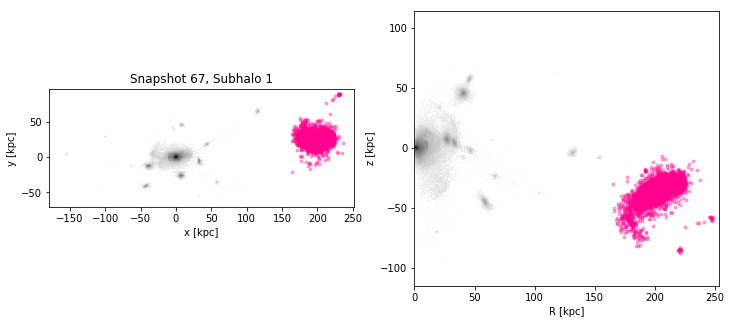

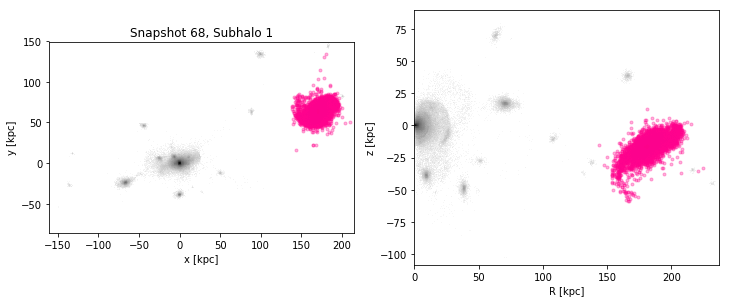

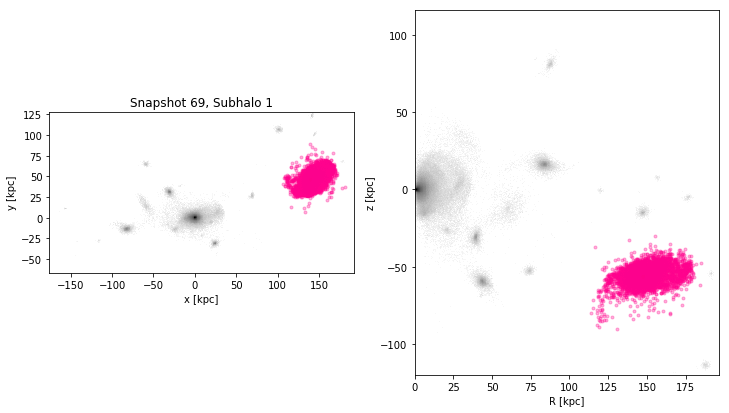

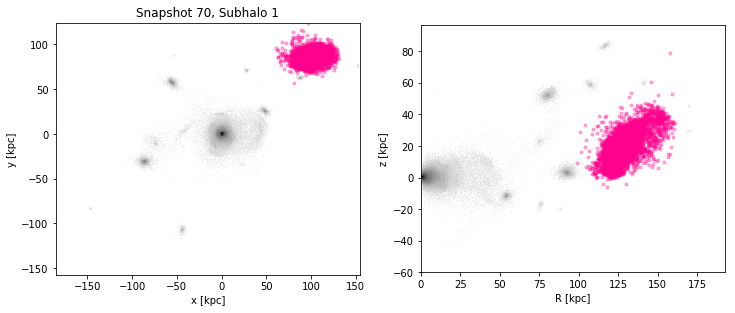

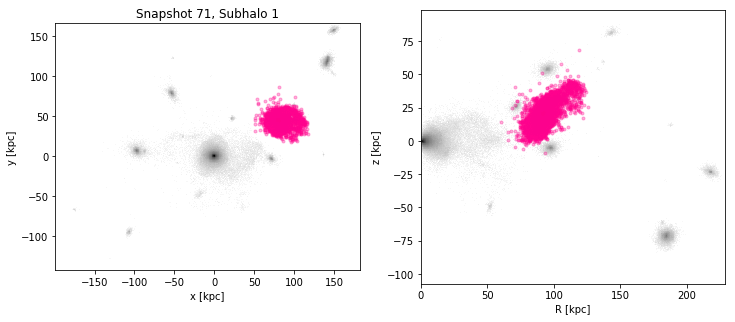

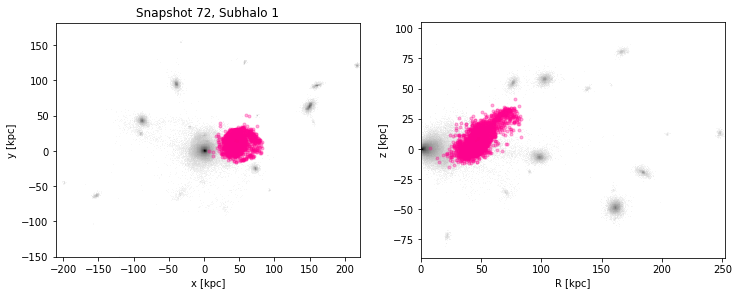

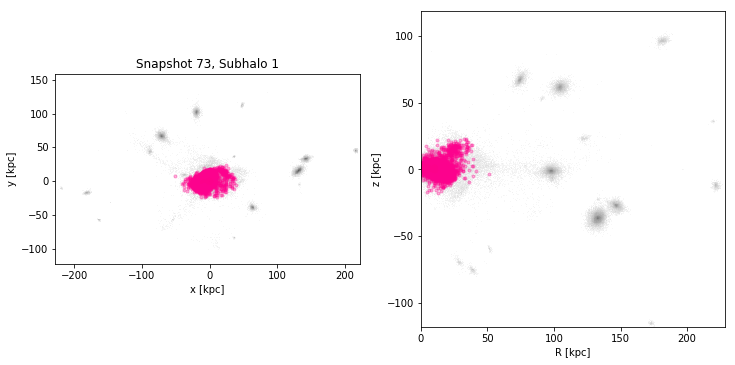

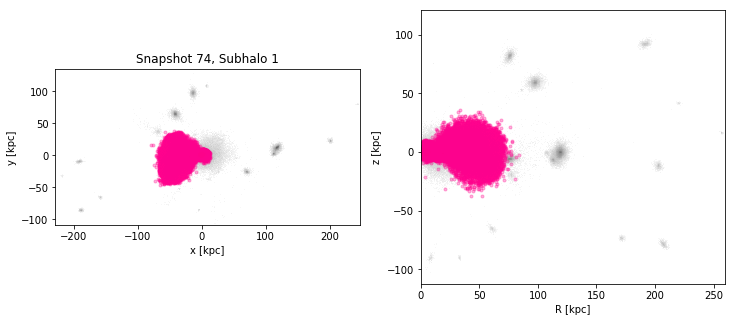

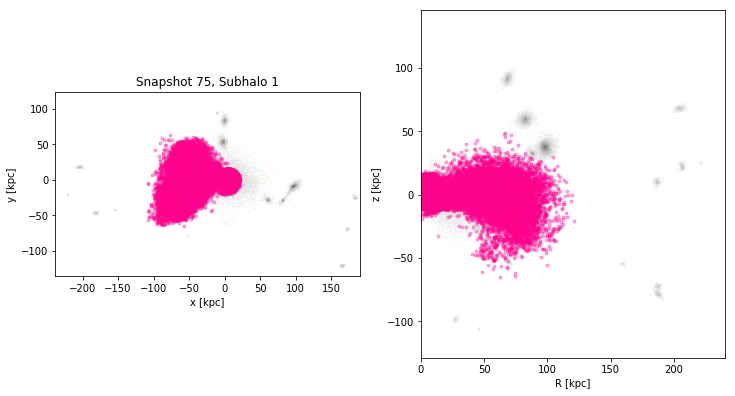

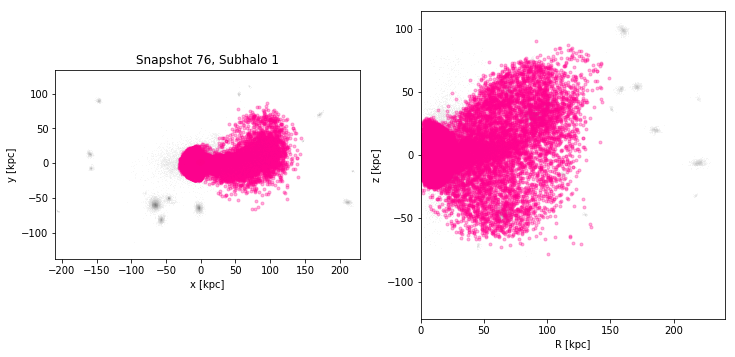

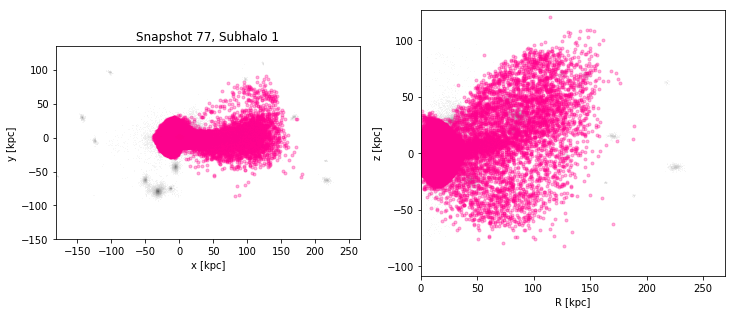

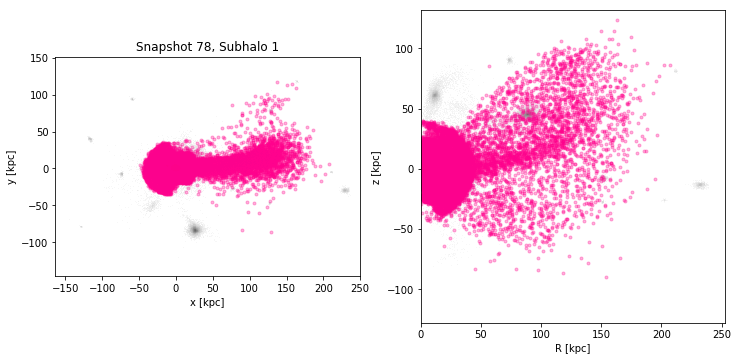

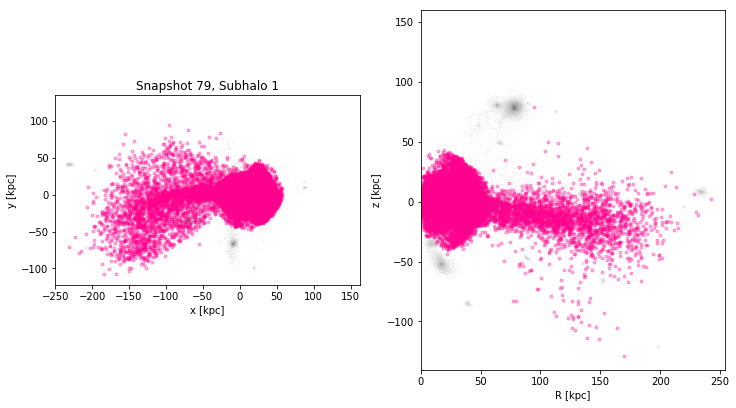

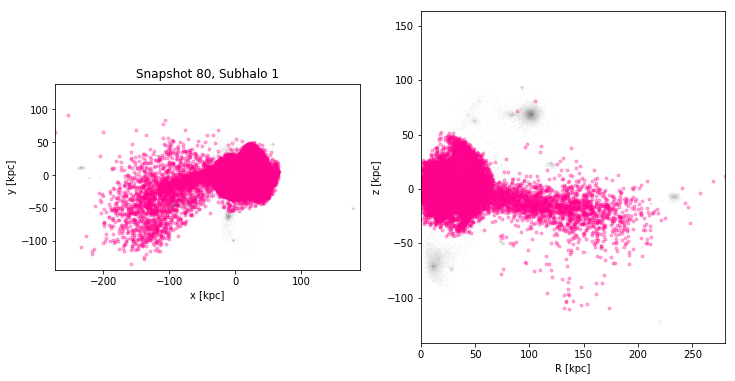

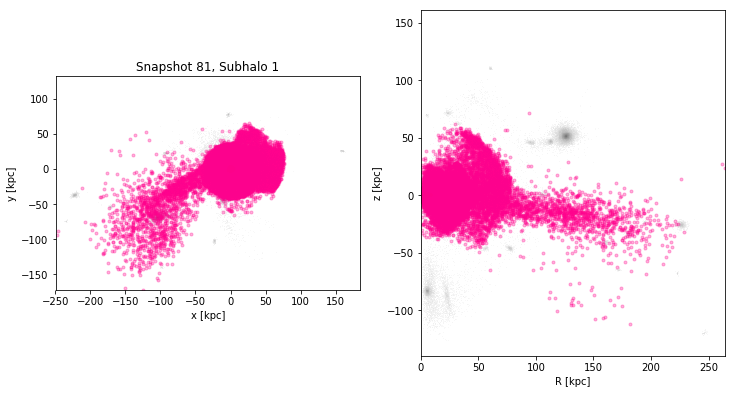

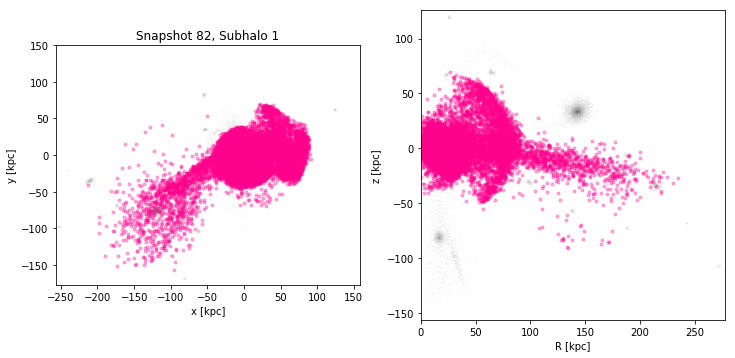

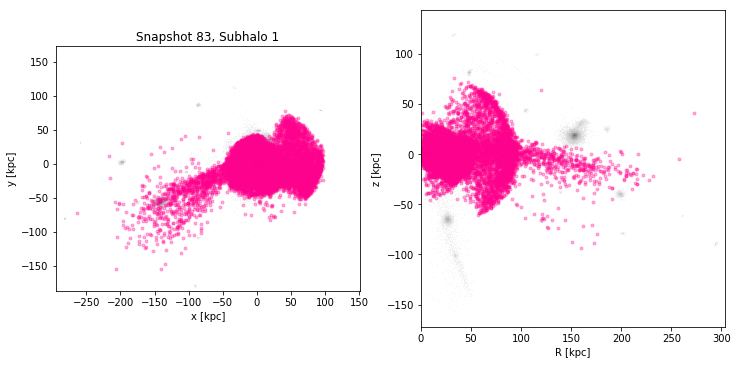

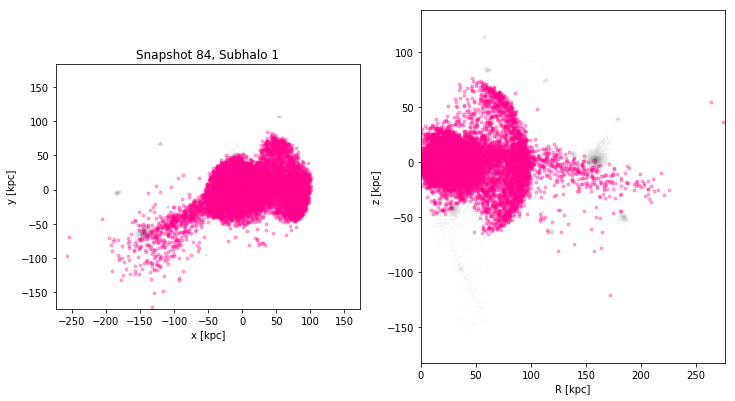

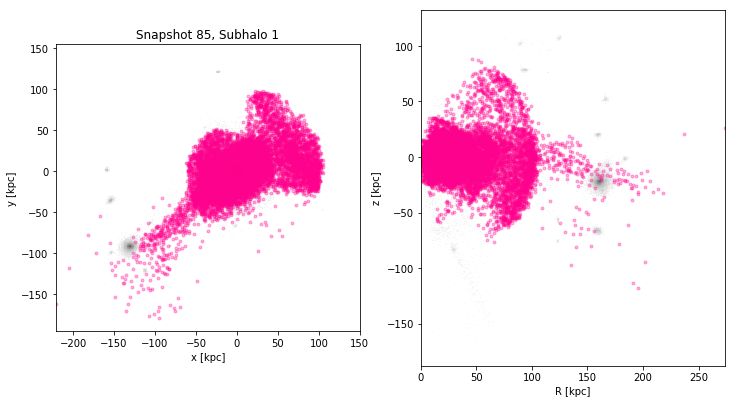

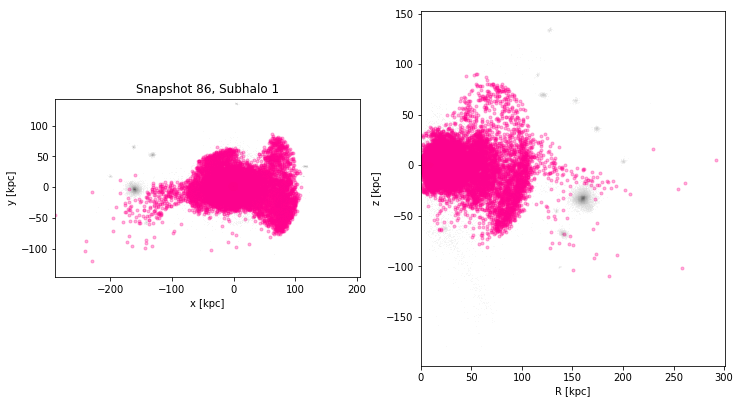

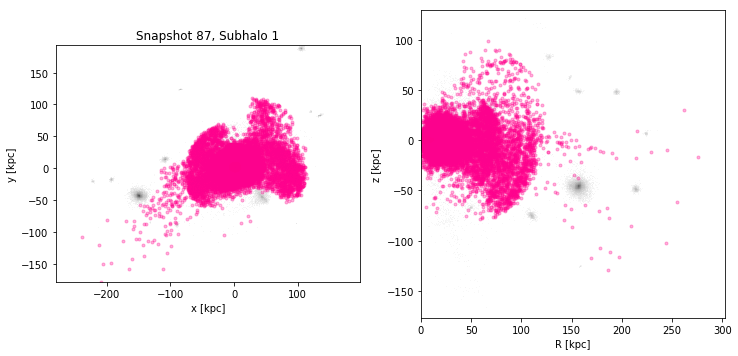

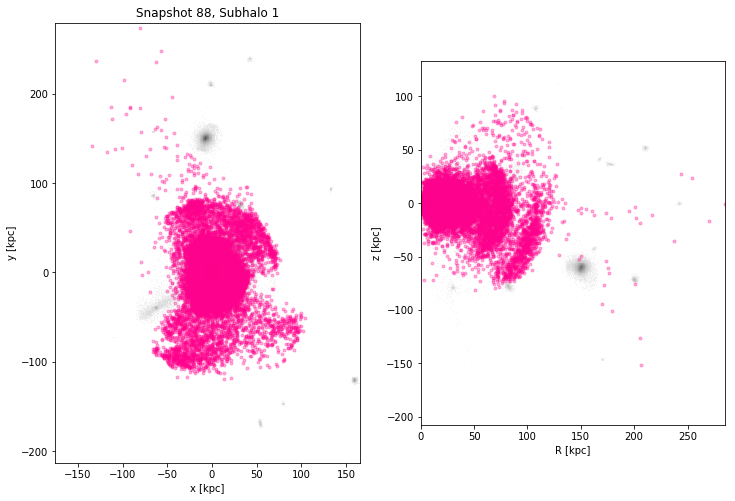

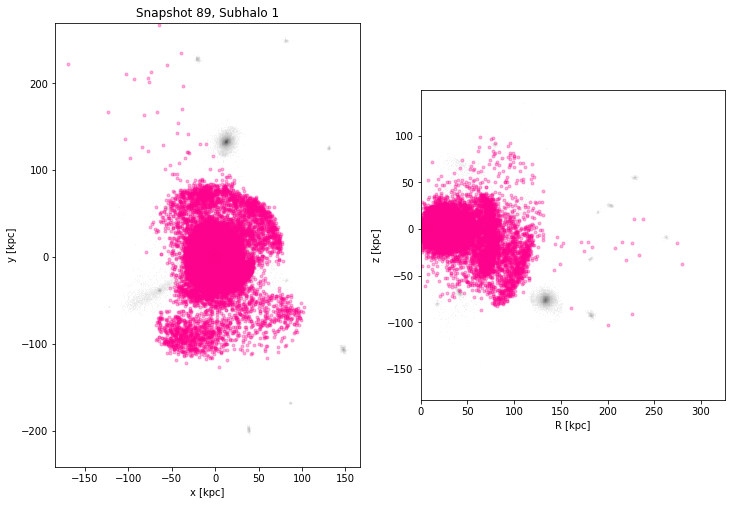

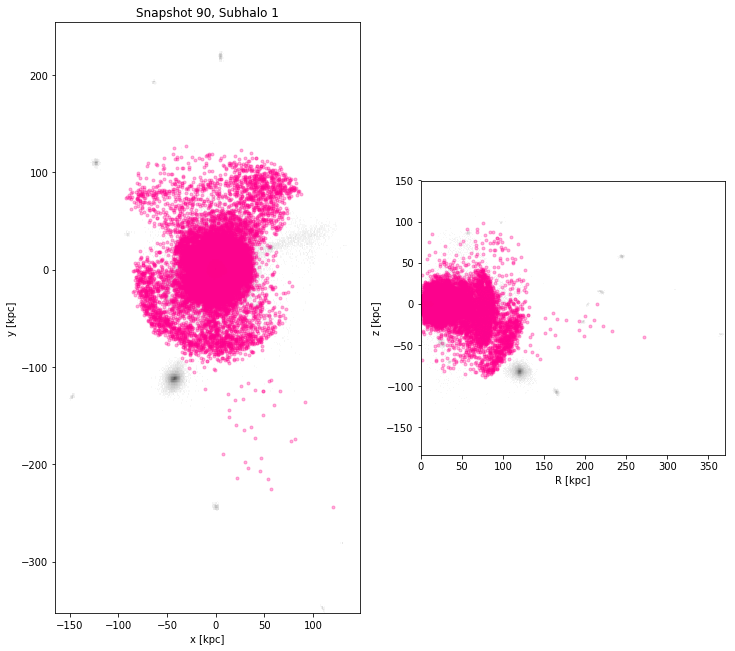

In [33]:
Galrad = 1000.*s.galrad
dwarf_following(Galrad, snappath, 67, 90)

24.085566401481628